# Estimator validation

This notebook contains code to generate Figure 2 of the paper. 

This notebook also serves to compare the estimates of the re-implemented scmemo with sceb package from Vasilis. 


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [877]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [7]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util

In [8]:
import sys
sys.path.append('/home/ssm-user/Github/single_cell_eb/')
sys.path.append('/home/ssm-user/Github/single_cell_eb/sceb')
import scdd

In [146]:
figpath = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig2/'

### Check 1D estimates of `sceb` with `scmemo`

Using the Poisson model. The outputs should be identical, this is for checking the implementation. 

In [20]:
data = sp.sparse.csr_matrix(simulate.simulate_transcriptomes(100, 20))
adata = sc.AnnData(data)
size_factors = scdd.dd_size_factor(adata)

In [21]:
_, M_dd = scdd.dd_1d_moment(adata, size_factor=size_factors)
var_scdd = scdd.M_to_var(M_dd)
print(var_scdd)

#time start: 0.0s
n_cell=100, n_gene=20
#total: 0.00s
[4.05811359e+00 8.65557033e+01 3.38042239e+00 8.67055877e+01
 5.87806859e-02 3.99841925e+01 8.48237731e+00 1.28562336e+01
 4.02345703e+00 2.43614751e+00 9.80252612e-02 1.62111844e+01
 1.05115668e+01 9.53143947e-01 1.36284024e+02 2.32362990e+01
 8.75613957e-01 9.43882965e+01 6.77484907e+01 5.34462511e-01]


In [22]:
imp.reload(estimator)
mean_scmemo, var_scmemo = estimator._poisson_1d(data, data.shape[0], size_factors)
print(var_scmemo)

[4.05811419e+00 8.65558825e+01 3.38042193e+00 8.67056078e+01
 5.87806855e-02 3.99841965e+01 8.48237715e+00 1.28562306e+01
 4.02345666e+00 2.43614724e+00 9.80252592e-02 1.62111701e+01
 1.05115720e+01 9.53144150e-01 1.36289603e+02 2.32362900e+01
 8.75614006e-01 9.43883035e+01 6.77483004e+01 5.34462544e-01]


In [23]:
df = pd.DataFrame()
df['size_factor'] = size_factors
df['inv_size_factor'] = 1/size_factors
df['inv_size_factor_sq'] = 1/size_factors**2
df['expr'] = data[:, 0].todense().A1
precomputed_size_factors = df.groupby('expr')['inv_size_factor'].mean(), df.groupby('expr')['inv_size_factor_sq'].mean()

In [24]:
imp.reload(estimator)
expr, count = np.unique(data[:, 0].todense().A1, return_counts=True)
print(estimator._poisson_1d((expr, count), data.shape[0], precomputed_size_factors))

[0.9063726711273193, 4.058114381881536]


### Check 2D estimates of `sceb` and `scmemo`

Using the Poisson model. The outputs should be identical, this is for checking the implementation. 

In [25]:
data = sp.sparse.csr_matrix(simulate.simulate_transcriptomes(1000, 4))
adata = sc.AnnData(data)
size_factors = scdd.dd_size_factor(adata)

In [26]:
mean_scdd, cov_scdd, corr_scdd = scdd.dd_covariance(adata, size_factors)
print(cov_scdd)

[[ 4.09247186e-01 -7.00641019e-03  1.11981475e-02 -5.42475049e-01]
 [-7.00641019e-03  3.07633212e-01 -6.79097739e-03 -3.44895561e-01]
 [ 1.11981475e-02 -6.79097739e-03  5.31315636e-01 -6.31933899e-01]
 [-5.42475049e-01 -3.44895561e-01 -6.31933899e-01  1.00000000e-12]]


In [27]:
imp.reload(estimator)
cov_scmemo = estimator._poisson_cov(data, data.shape[0], size_factors, idx1=[0, 1, 2], idx2=[1, 2, 3])
print(cov_scmemo)

[[-0.00700641  0.01119815 -0.54247505]
 [ 0.30763321 -0.00679098 -0.34489556]
 [-0.00679098  0.53131564 -0.6319339 ]]


In [28]:
expr, count = np.unique(data[:, :2].toarray(), return_counts=True, axis=0)

df = pd.DataFrame()
df['size_factor'] = size_factors
df['inv_size_factor'] = 1/size_factors
df['inv_size_factor_sq'] = 1/size_factors**2
df['expr1'] = data[:, 0].todense().A1
df['expr2'] = data[:, 1].todense().A1

precomputed_size_factors = df.groupby(['expr1', 'expr2'])['inv_size_factor'].mean(), df.groupby(['expr1', 'expr2'])['inv_size_factor_sq'].mean()

In [30]:
cov_scmemo = estimator._poisson_cov((expr[:, 0], expr[:, 1], count), data.shape[0], size_factor=precomputed_size_factors)
print(cov_scmemo)

-0.007006410053126586


### Variance/correlation estimation while varying q_sq

In [885]:
q = 0.07
q_sq_list = [0.07**2+1e-6, 0.005, 0.006]

In [886]:
import warnings
warnings.filterwarnings("ignore")


In [890]:
imp.reload(simulate)

true_data = simulate.simulate_transcriptomes(5000, 10000, correlated=False)
true_relative_data = true_data / true_data.sum(axis=1).reshape(-1, 1)

0.1389
0.1442
0.1685


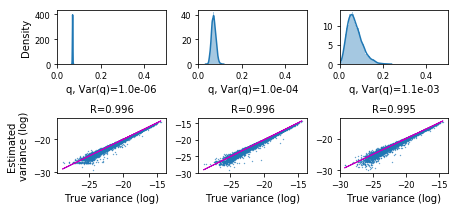

In [892]:
plt.figure(figsize=(7, 3))
plt.subplots_adjust(hspace=1, wspace=0.3)
num_subplot_col = len(q_sq_list)
num_subplot_row = 2

for col_num, q_sq in enumerate(q_sq_list):
    
    qs, captured_data = simulate.capture_sampling(true_data, q, q_sq)
    Nr = captured_data.sum(axis=1).mean()
    captured_relative_data = captured_data/captured_data.sum(axis=1).reshape(-1, 1)
    adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))
    
    x_true, y_true = true_relative_data.mean(axis=0), true_relative_data.var(axis=0)
    x_obs, y_obs = captured_relative_data.mean(axis=0), captured_relative_data.var(axis=0)
    
    _, M_dd = scdd.dd_1d_moment(adata, size_factor=scdd.dd_size_factor(adata), verbose=False, Nr=Nr)
    var_scdd = scdd.M_to_var(M_dd)
    
#     obs_cell_sizes = captured_data.sum(axis=1).reshape(-1, 1)
#     mm_var = ((captured_data**2 - (1-0.1)*captured_data)/(obs_cell_sizes**2-obs_cell_sizes)).mean(axis=0) - (captured_data/obs_cell_sizes).mean(axis=0)**2
    
#     var_scdd = mm_var
    
    condition = np.log(var_scdd) > -30
    
#     true_corrs = np.corrcoef(true_data, rowvar=False).ravel()
#     estimated_corrs = corr_scdd.ravel()
#     corr_cond = np.isfinite(estimated_corrs)
#     true_corrs = true_corrs[corr_cond]
#     estimated_corrs = estimated_corrs[corr_cond]
        
    plt.subplot(num_subplot_row, num_subplot_col, col_num+1)
    sns.distplot(qs)
    plt.xlabel('q, Var(q)={:.1e}'.format(q_sq-q**2))
    plt.xlim(0, 0.5)
    if col_num == 0:
        plt.ylabel('Density')
        
    plt.subplot(num_subplot_row, num_subplot_col, col_num+1+num_subplot_col)
    plt.plot(np.log(y_true[condition]), np.log(y_true[condition]), color='m', lw=1)
    plt.scatter(np.log(y_true[condition]), np.log(var_scdd[condition]), s=0.1)
    plt.xlabel('True variance (log)');
    if col_num == 0:
        plt.ylabel('Estimated\nvariance (log)')
    plt.title('R={:.3f}'.format(stats.pearsonr(var_scdd[condition], y_true[condition])[0]))
    print((var_scdd>y_true).mean())
plt.savefig(figpath + 'variance_q_sq_robust.png', bbox_inches='tight')

### Estimation of moments from arbitrary underyling true distributions

In [859]:
# Generate cell sizes
cell_sizes = np.exp(stats.norm.rvs(11, 0.01, 20000)).astype(int)

# Generate true expression of a single gene
expr_1 = np.exp(stats.norm.rvs(6, 0.08, 12000)).astype(int)
# expr = expr_1
expr_2 = stats.norm.rvs(450, 10, 8000).astype(int)
expr = np.concatenate([expr_1, expr_2])

# Generate the q's
q = 0.07
q_sq = 0.005
m = q
v = q_sq - q**2
alpha = m*(m*(1-m)/v - 1)
beta = (1-m)*(m*(1-m)/v - 1)
qs = stats.beta.rvs(alpha, beta, size=20000)

# Generate the observed distribution
obs_expr = stats.hypergeom.rvs(M=cell_sizes, n=expr, N=(qs*cell_sizes).astype(int))
obs_cell_sizes = (qs*cell_sizes).astype(int)

# Calculate relative abundances
rel_obs_expr = obs_expr/obs_cell_sizes
rel_expr = expr/cell_sizes

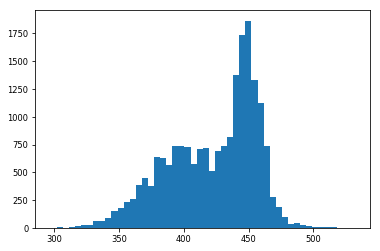

In [861]:
plt.hist(expr, bins=50);

In [897]:
# method of moments estimator
mm_var = ((obs_expr**2 - obs_expr)/(obs_cell_sizes**2-obs_cell_sizes)).mean() - (obs_expr/obs_cell_sizes).mean()**2

mm_std = np.sqrt(mm_var)
print(mm_std, rel_expr.std())

0.0004746187869741726 0.0005693636668474205


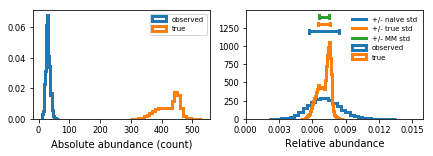

In [898]:
plt.figure(figsize=(7, 2))
plt.subplot(1, 2, 1)
plt.hist(obs_expr, density=True, bins=24, histtype='step', lw=3);
plt.hist(expr, density=True, bins=26, histtype='step', lw=3);
plt.legend(['observed', 'true'])
plt.xlabel('Absolute abundance (count)')
# plt.ylim(0, 0.5)

plt.subplot(1, 2, 2);
plt.hist(rel_obs_expr, label='observed', density=True, bins=30, histtype='step', lw=3)
plt.hist(rel_expr, label='true', density=True, bins=50, histtype='step', lw=3)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.003))
plt.xlabel('Relative abundance')
plt.legend()
# plt.ylim(0, 600)
plt.xlim(0, 0.016)

add = 800

# Plot the naive variance calculation
plt.plot([rel_expr.mean() - rel_obs_expr.std(), rel_expr.mean() + rel_obs_expr.std()], [add + 400,add +  400], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], lw=3, label='+/- naive std')
plt.plot([rel_expr.mean() - rel_obs_expr.std(), rel_expr.mean() - rel_obs_expr.std()], [add + 380, add + 420], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], lw=3)
plt.plot([rel_expr.mean() + rel_obs_expr.std(), rel_expr.mean() + rel_obs_expr.std()], [add + 380, add + 420], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], lw=3)

# Plot the true variance calculation
plt.plot([rel_expr.mean() - rel_expr.std(), rel_expr.mean() + rel_expr.std()], [add + 470 + 30, add + 470+ 30], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], lw=3, label='+/- true std')
plt.plot([rel_expr.mean() - rel_expr.std(), rel_expr.mean() - rel_expr.std()], [add + 450+ 30, add + 490+ 30], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], lw=3)
plt.plot([rel_expr.mean() + rel_expr.std(), rel_expr.mean() + rel_expr.std()], [add + 450+ 30, add + 490+ 30], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], lw=3)

# MM estimate
plt.plot([rel_expr.mean() - mm_std, rel_expr.mean() + mm_std], [add + 540+ 30 + 30, add + 540+ 30 + 30], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], lw=3, label='+/- MM std')
plt.plot([rel_expr.mean() - mm_std, rel_expr.mean() - mm_std], [add + 520+ 30 + 30, add + 560+ 30 + 30], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], lw=3)
plt.plot([rel_expr.mean() + mm_std, rel_expr.mean() + mm_std], [add + 520+ 30 + 30, add + 560+ 30 + 30], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], lw=3)

plt.legend(frameon=False)
plt.savefig(figpath + 'variance_estimation.pdf', bbox_inches='tight')

# plt.yscale('log')